#### Setup

In [1]:
import matplotlib.pyplot as plt

import torch

import pyciemss
from pyciemss.PetriNetODE.interfaces import setup_model, reset_model, intervene, sample, calibrate, optimize, load_petri_model
import mira
from pyciemss.utils import get_tspan

import warnings
warnings.filterwarnings('ignore')

## SIR MIRA

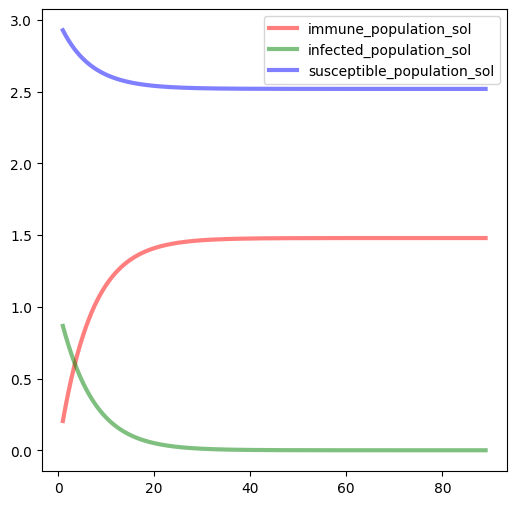

In [17]:
from mira.examples.sir import sir_parameterized as sir
full_tspan = get_tspan(1, 89, 890)
mira_model = load_petri_model(sir, add_uncertainty=True)
mira_model = setup_model(mira_model, start_time=0, start_state=dict(susceptible_population=3.0,
                                                                    infected_population=1.0,
                                                                    immune_population=0.0))
solution = sample(mira_model, timepoints=full_tspan, num_samples=1)

fig = plt.figure(facecolor='w', figsize=(6, 6))
ax = fig.add_subplot(111, axisbelow=True)
colors=['red','green','blue','black','gold']
for i,var in enumerate(list(solution.keys())[2:]):
    ax.plot(full_tspan, solution[var].squeeze().detach().numpy(), colors[i],
            alpha=0.5, lw=3, label=var)
ax.legend()
plt.show()

## SIR Handmade

SIR_with_uncertainty()


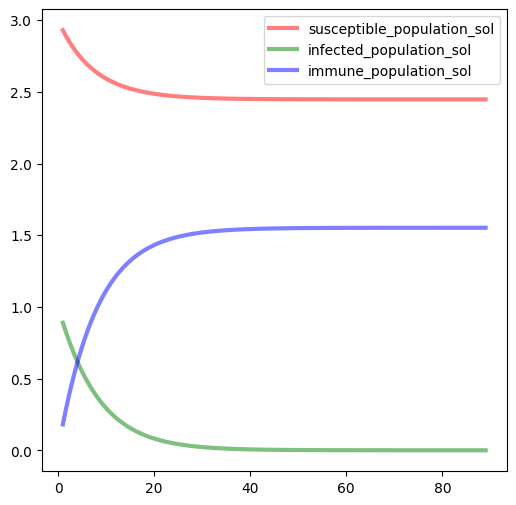

In [16]:
from pyciemss.PetriNetODE.models import SIR_with_uncertainty
from pyro.infer import Predictive
full_tspan = get_tspan(1, 89, 890)
SIR_model  = SIR_with_uncertainty(N=100.0, beta=0.1, gamma=0.2) # N here unecessary, makes its own
SIR_model = setup_model(SIR_model, start_time=0, start_state=dict(susceptible_population=3.0,
                                                                  infected_population=1.0,
                                                                  immune_population=0.0))
solution   = sample(SIR_model,full_tspan,1)

fig = plt.figure(facecolor='w', figsize=(6, 6))
ax = fig.add_subplot(111, axisbelow=True)
colors=['red','green','blue','black','gold']
for i,var in enumerate(list(solution.keys())[2:]):
    ax.plot(full_tspan, solution[var].squeeze().detach().numpy(), colors[i],
            alpha=0.5, lw=3, label=var)
ax.legend()
plt.show()

In [3]:
full_tspan = get_tspan(1, 89, 89) #bad idea

num_samples = 100

# Total population, N.
N = 100000.0
# Initial number of infected and recovered individuals, I0 and R0.
V0, I0, Iv0, R0 = 0., 81.0, 0., 0. #may want to revisit this choice, consider setting I0 to 1 (there will not be zero recovered people when there are 81 infectious people)
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - Iv0 - V0 - R0

# 18 - 24 year olds
plot_I_obs = dict(I_obs=torch.tensor([81.47, 84.3, 86.44, 89.66, 93.32, 94.1, 96.31])) #these numbers make no sense, why not use whole numbers?
I_obs = [(float(i+1), dict(I_obs=obs/N)) for i, obs in enumerate([81.47, 84.3, 86.44, 89.66, 93.32, 94.1, 96.31])]

observed_tspan = get_tspan(1, len(I_obs), len(I_obs)) #also bad

In [6]:
from pyciemss.PetriNetODE.models import MIRA_I_obs_with_scaled_Gaussian_noise
model_json = '../../test/models/SVIIvR_mira.json'
petri_net_ode_model = MIRA_I_obs_with_scaled_Gaussian_noise.from_mira(model_json)
petri_net_ode_model.total_population = N
petri_net_ode_model.data_reliability = 4.0
petri_net_ode_model

MIRA_I_obs_with_scaled_Gaussian_noise(
	beta = Uniform(low: 0.18000000715255737, high: 0.2199999988079071),
	betaV = Uniform(low: 0.03375000134110451, high: 0.04125000163912773),
	nu = Uniform(low: 0.0044999998062849045, high: 0.005499999970197678),
	gamma = Uniform(low: 0.1574999988079071, high: 0.19249999523162842),
	gammaV = Uniform(low: 0.22499999403953552, high: 0.2750000059604645),
	total_population = 100000.0,
	data_reliability = 4.0
)

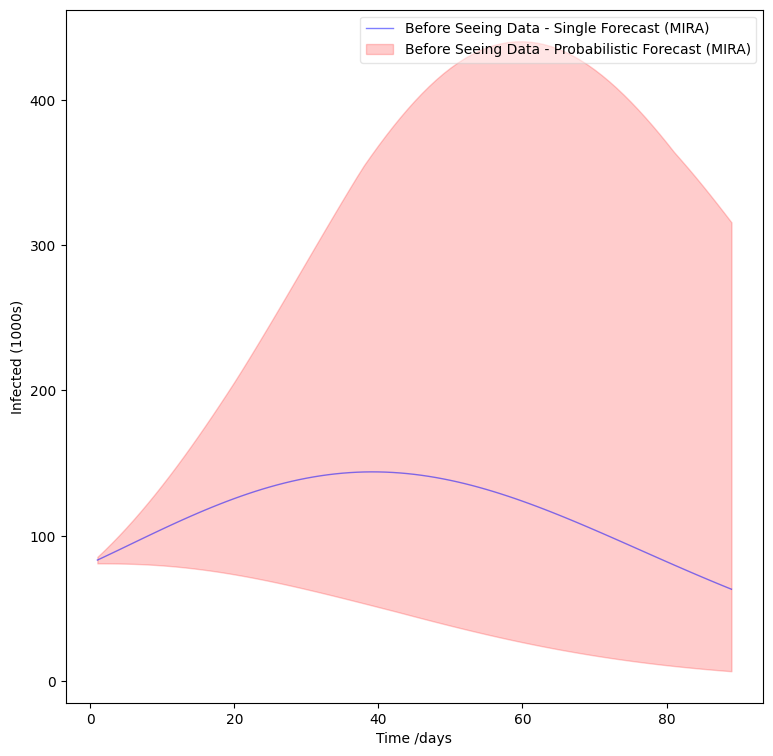

In [8]:
initialized_petri_net_ode_model = setup_model(petri_net_ode_model, start_time=0.0, start_state=dict(S=S0, V=V0, I=I0, I_v=Iv0, R=R0))

single_prior =sample(initialized_petri_net_ode_model, timepoints=full_tspan, num_samples=1)
single_prior['I_obs'] = single_prior['I_sol'] + single_prior['I_v_sol']

prior_prediction =sample(initialized_petri_net_ode_model, timepoints=full_tspan, num_samples=100)
prior_prediction['I_obs'] = prior_prediction['I_sol'] + prior_prediction['I_v_sol']

ax = plot_trajectory(single_prior, full_tspan, ax=setup_ax(), color="blue", marker='', lw=1., label="Before Seeing Data - Single Forecast (MIRA)")
ax = plot_predictive(prior_prediction, full_tspan, ax=ax, label="Before Seeing Data - Probabilistic Forecast (MIRA)", color="red", alpha=0.2)